# 2-D image manifold: images

In [16]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import FFHQStyleGAN2DLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow
import plot_settings as ps


In [17]:
ps.setup()

## Options

In [18]:
highres = False


## Helper function to go from torch to numpy conventions

In [19]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Load models

In [20]:
def load_model(
    filename,
    outerlayers=20,
    innerlayers=6,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=1,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        2,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [21]:
def load_emf_model(
    filename,
    outerlayers=20,
    innerlayers=6,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=1,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    encoder = create_image_encoder(
        3,
        64,
        64,
        latent_dim=2,
        context_features=None,
    )
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        2,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = EncoderManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=2,
        encoder=encoder,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [22]:
mf = load_model("mf_2_gan2d_april")
emf = load_emf_model("emf_2_gan2d_april")
pie = load_model("pie_2_gan2d_april")

/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


## True (GAN) image manifold

In [ ]:
boundary = 1.5
resolution = 7
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
gan_zs = np.vstack(each_grid).T

gan_images = np.load("../data/samples/gan2d/grid{}.npy".format("_highres" if highres else ""))
gan_images = gan_images.reshape((9, 9, 3, 64, 64))
gan_images = gan_images[1:-1, 1:-1, :, :, :]
gan_images = gan_images.reshape((49, 3, 64, 64))
gan_images.shape

In [ ]:
size = 0.45
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH)

for z, image in zip(gan_zs, gan_images):
    image_ = np.transpose(image, [1,2,0])
    plt.imshow(image_, extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel("StyleGAN latent variable $z_0$", labelpad=4)
plt.ylabel("StyleGAN latent variable $z_1$", labelpad=1)
plt.xlim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.ylim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.xticks([-1., 0., 1.])
plt.yticks([-1., 0., 1.])
ax.tick_params(axis='y', which='major', pad=1)

plt.savefig("../figures/gan2d_grid.pdf", dpi=600)
    

## MF manifold

In [ ]:
boundary = 1.5
resolution = 7
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
mf_zs = np.vstack(each_grid).T

z_ = torch.tensor(mf_zs, dtype=torch.float)
mf_images = mf.sample(u=z_, n=resolution**2).detach().numpy()
mf_images.shape


In [ ]:
size = 0.45
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH)

for z, image in zip(mf_zs, mf_images):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"$\mathcal{M}$-flow latent variable $\tilde{u}_0$", labelpad=4)
plt.ylabel(r"$\mathcal{M}$-flow latent variable $\tilde{u}_1$", labelpad=1)
plt.xlim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.ylim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.xticks([-1., 0., 1.])
plt.yticks([-1., 0., 1.])
ax.tick_params(axis='y', which='major', pad=1)

plt.savefig("../figures/gan2d_mf_grid.pdf", dpi=600)
    

## EMF manifold

In [ ]:
boundary = 1.5
resolution = 7
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
emf_zs = np.vstack(each_grid).T

z_ = torch.tensor(emf_zs, dtype=torch.float)
emf_images = emf.sample(u=z_, n=resolution**2).detach().numpy()
emf_images.shape


In [ ]:
size = 0.45
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH)

for z, image in zip(emf_zs, emf_images):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"$\mathcal{M}_e$-flow latent variable $\tilde{u}_0$", labelpad=4)
plt.ylabel(r"$\mathcal{M}_e$-flow latent variable $\tilde{u}_1$", labelpad=1)
plt.xlim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.ylim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.xticks([-1., 0., 1.])
plt.yticks([-1., 0., 1.])
ax.tick_params(axis='y', which='major', pad=1)

plt.savefig("../figures/gan2d_emf_grid.pdf", dpi=600)
    

## PIE manifold

In [ ]:
boundary = 1.5
resolution = 7
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
pie_zs = np.vstack(each_grid).T

z_ = torch.tensor(pie_zs, dtype=torch.float)
pie_images = pie.sample(u=z_, n=resolution**2, sample_orthogonal=False).detach().numpy()
pie_images_orth = pie.sample(u=z_, n=resolution**2, sample_orthogonal=True).detach().numpy()
pie_images.shape


In [ ]:
size = 0.45
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH)

for z, image in zip(pie_zs, pie_images):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"PIE latent variable $\tilde{u}_0$", labelpad=4)
plt.ylabel(r"PIE latent variable $\tilde{u}_1$", labelpad=1)
plt.xlim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.ylim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.xticks([-1., 0., 1.])
plt.yticks([-1., 0., 1.])
ax.tick_params(axis='y', which='major', pad=1)

plt.savefig("../figures/gan2d_pie_grid.pdf", dpi=600)
    

In [ ]:
size = 0.45
fig, ax = ps.figure(height=0.33*ps.TEXTWIDTH)

for z, image in zip(pie_zs, pie_images_orth):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"PIE latent variable $\tilde{u}_0$", labelpad=4)
plt.ylabel(r"PIE latent variable $\tilde{u}_1$", labelpad=1)
plt.xlim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
plt.ylim(-1.5 - 1.3*size/2, 1.5 + 1.3*size/2)
ax.tick_params(axis='y', which='major', pad=1)

plt.savefig("../figures/gan2d_pie_grid_sampling_v.pdf", dpi=600)
    

## Sample comparison

In [23]:
x_gen_pie_sample_v = pie.sample(u=None, n=20, sample_orthogonal=True).detach().numpy()

In [46]:
test_idx=list(range(20))
n = 8

x_test = 0.5 + 255. * np.load("../data/samples/gan2d/test.npy")[[0,1,2,3,4,8,10,13]]
x_gen_af = np.load("../data/results/flow_2_gan2d_april_samples.npy")[[1,4,6,7,9,10,12,19]]
x_gen_pie = np.load("../data/results/pie_2_gan2d_april_samples.npy")[list(range(8))]
x_gen_pie_ = x_gen_pie_sample_v[[0,2,6,11,12,14,16,17]]
x_gen_mf = np.load("../data/results/mf_2_gan2d_april_samples.npy")[[0,1,2,3,6,7,9,13]]
x_gen_emf = np.load("../data/results/emf_2_gan2d_april_samples.npy")[[0,1,2,6,8,10,11,19]]


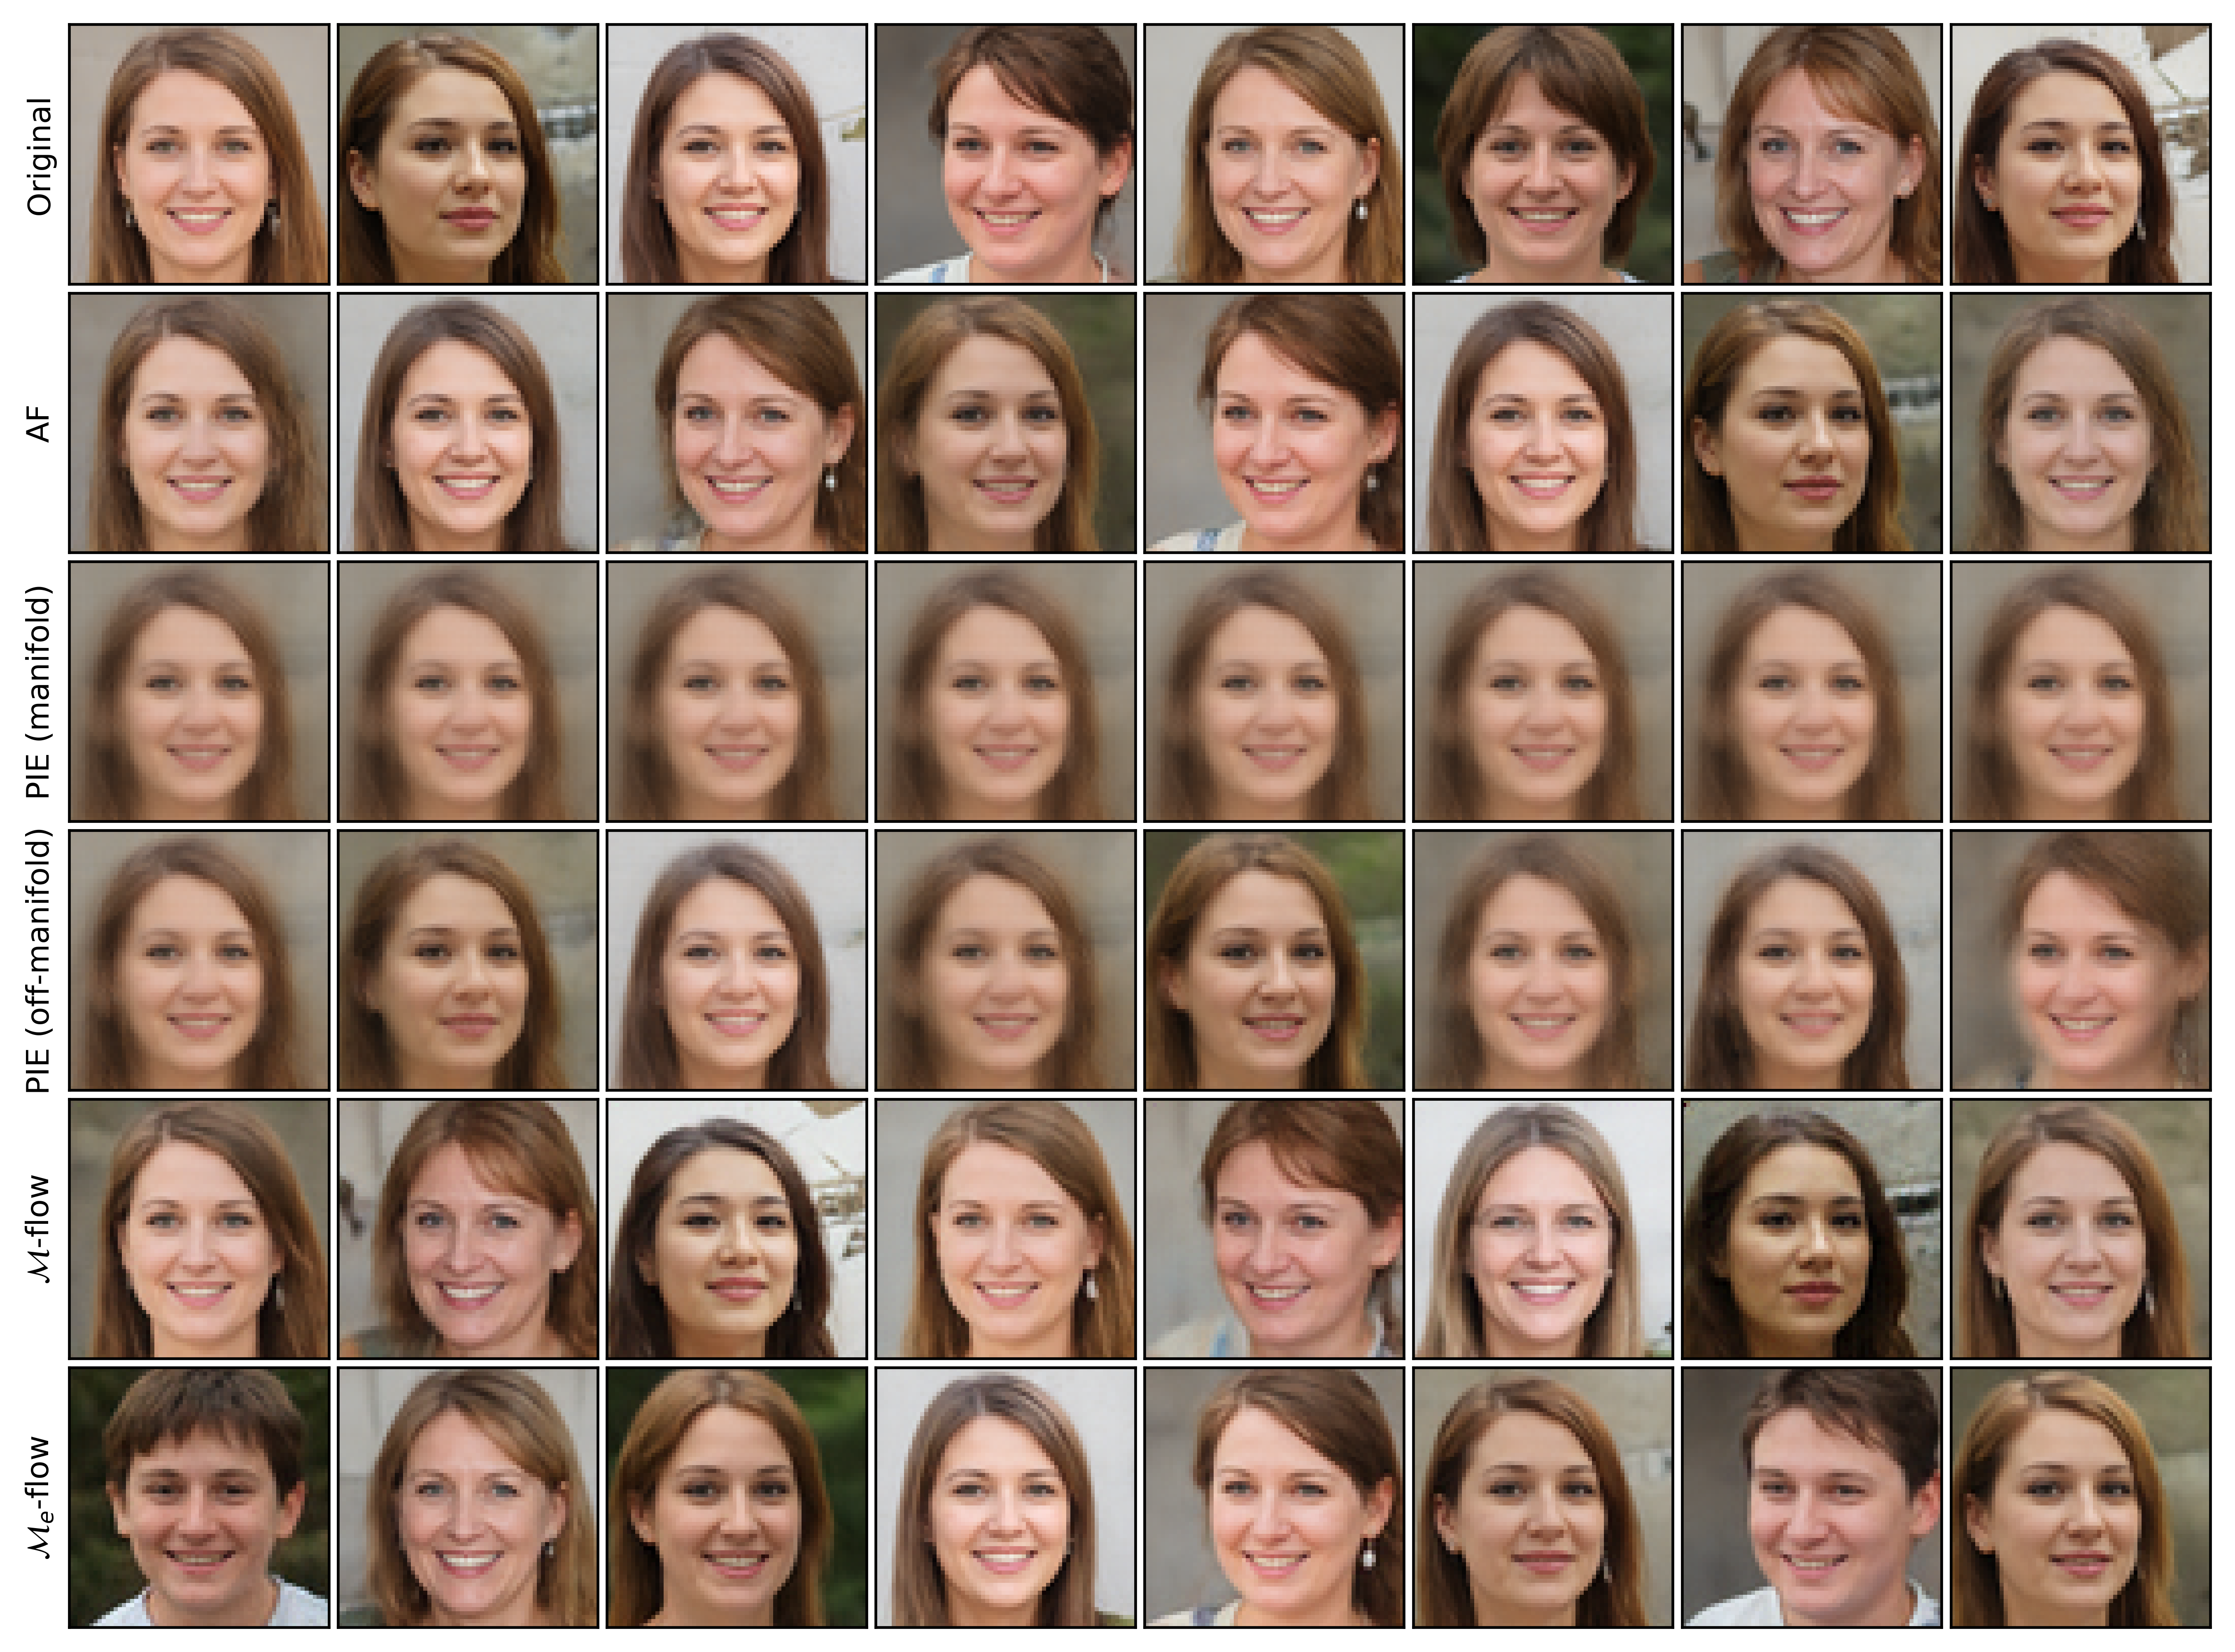

In [47]:
fig, gs = ps.grid_width(n, 6, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(n):
    for j, (x, label) in enumerate(zip(
        [x_test, x_gen_af, x_gen_pie, x_gen_pie_, x_gen_mf, x_gen_emf],
        ["Original", "AF", r"PIE (manifold)", r"PIE (off-manifold)", r"$\mathcal{M}$-flow", r"$\mathcal{M}_e$-flow"]
    )):
        
        ax = plt.subplot(gs[j*n + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan2d_samples.pdf")


## Test samples and projections to learned manifolds

In [6]:
test_idx=[0,1,2,3,4,8,10,13]
n_test = len(test_idx)

x_test = 0.5 + 255. * np.load("../data/samples/gan2d/test.npy")[test_idx]
x_reco_mf = np.load("../data/results/mf_2_gan2d_april_model_x_reco_test.npy")[test_idx]
x_reco_emf = np.load("../data/results/emf_2_gan2d_april_model_x_reco_test.npy")[test_idx]
# x_reco_pie = np.load("../data/results/pie_2_gan2d_april_model_x_reco_test.npy")[test_idx]


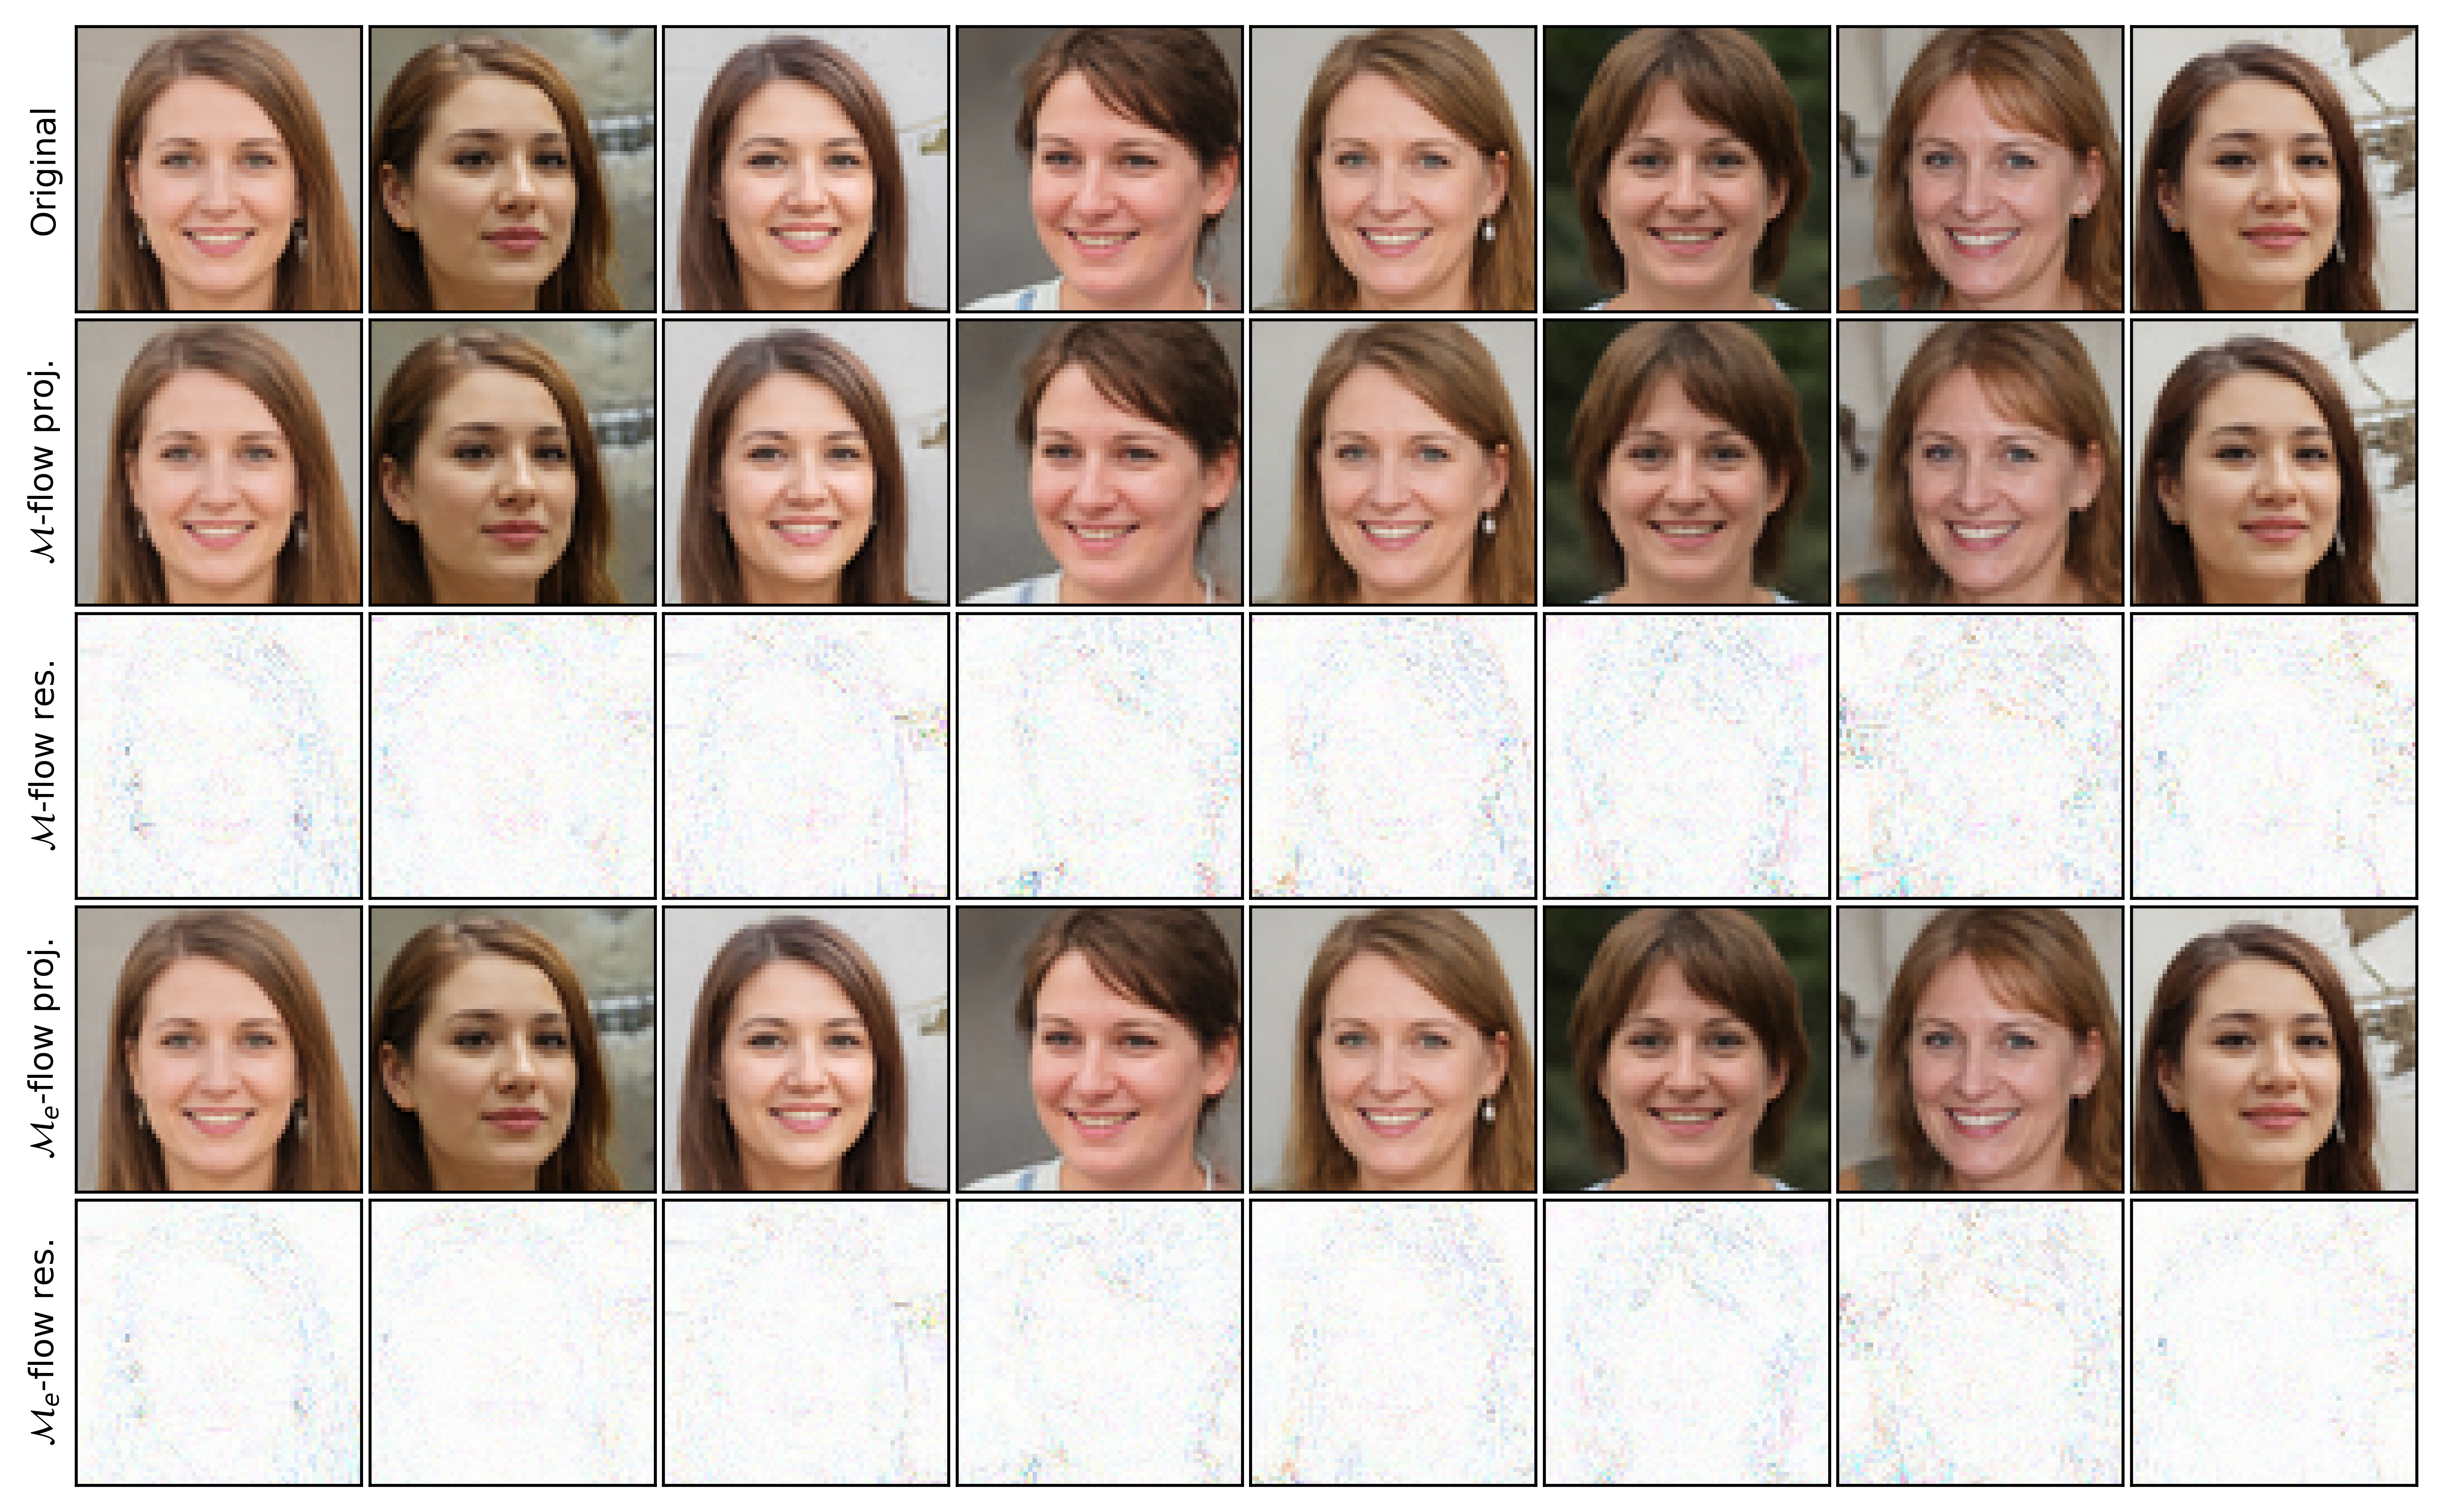

In [48]:
nrows = 5
enhance = 4
labels = ["Original", "$\mathcal{M}$-flow proj.", r"$\mathcal{M}$-flow res.", "$\mathcal{M}_e$-flow proj.", "$\mathcal{M}_e$-flow res."]

fig, gs = ps.grid_width(n_test, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(n_test):
    xs = [
        trf(x_test[i]),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * n_test + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan2d_projections.pdf")


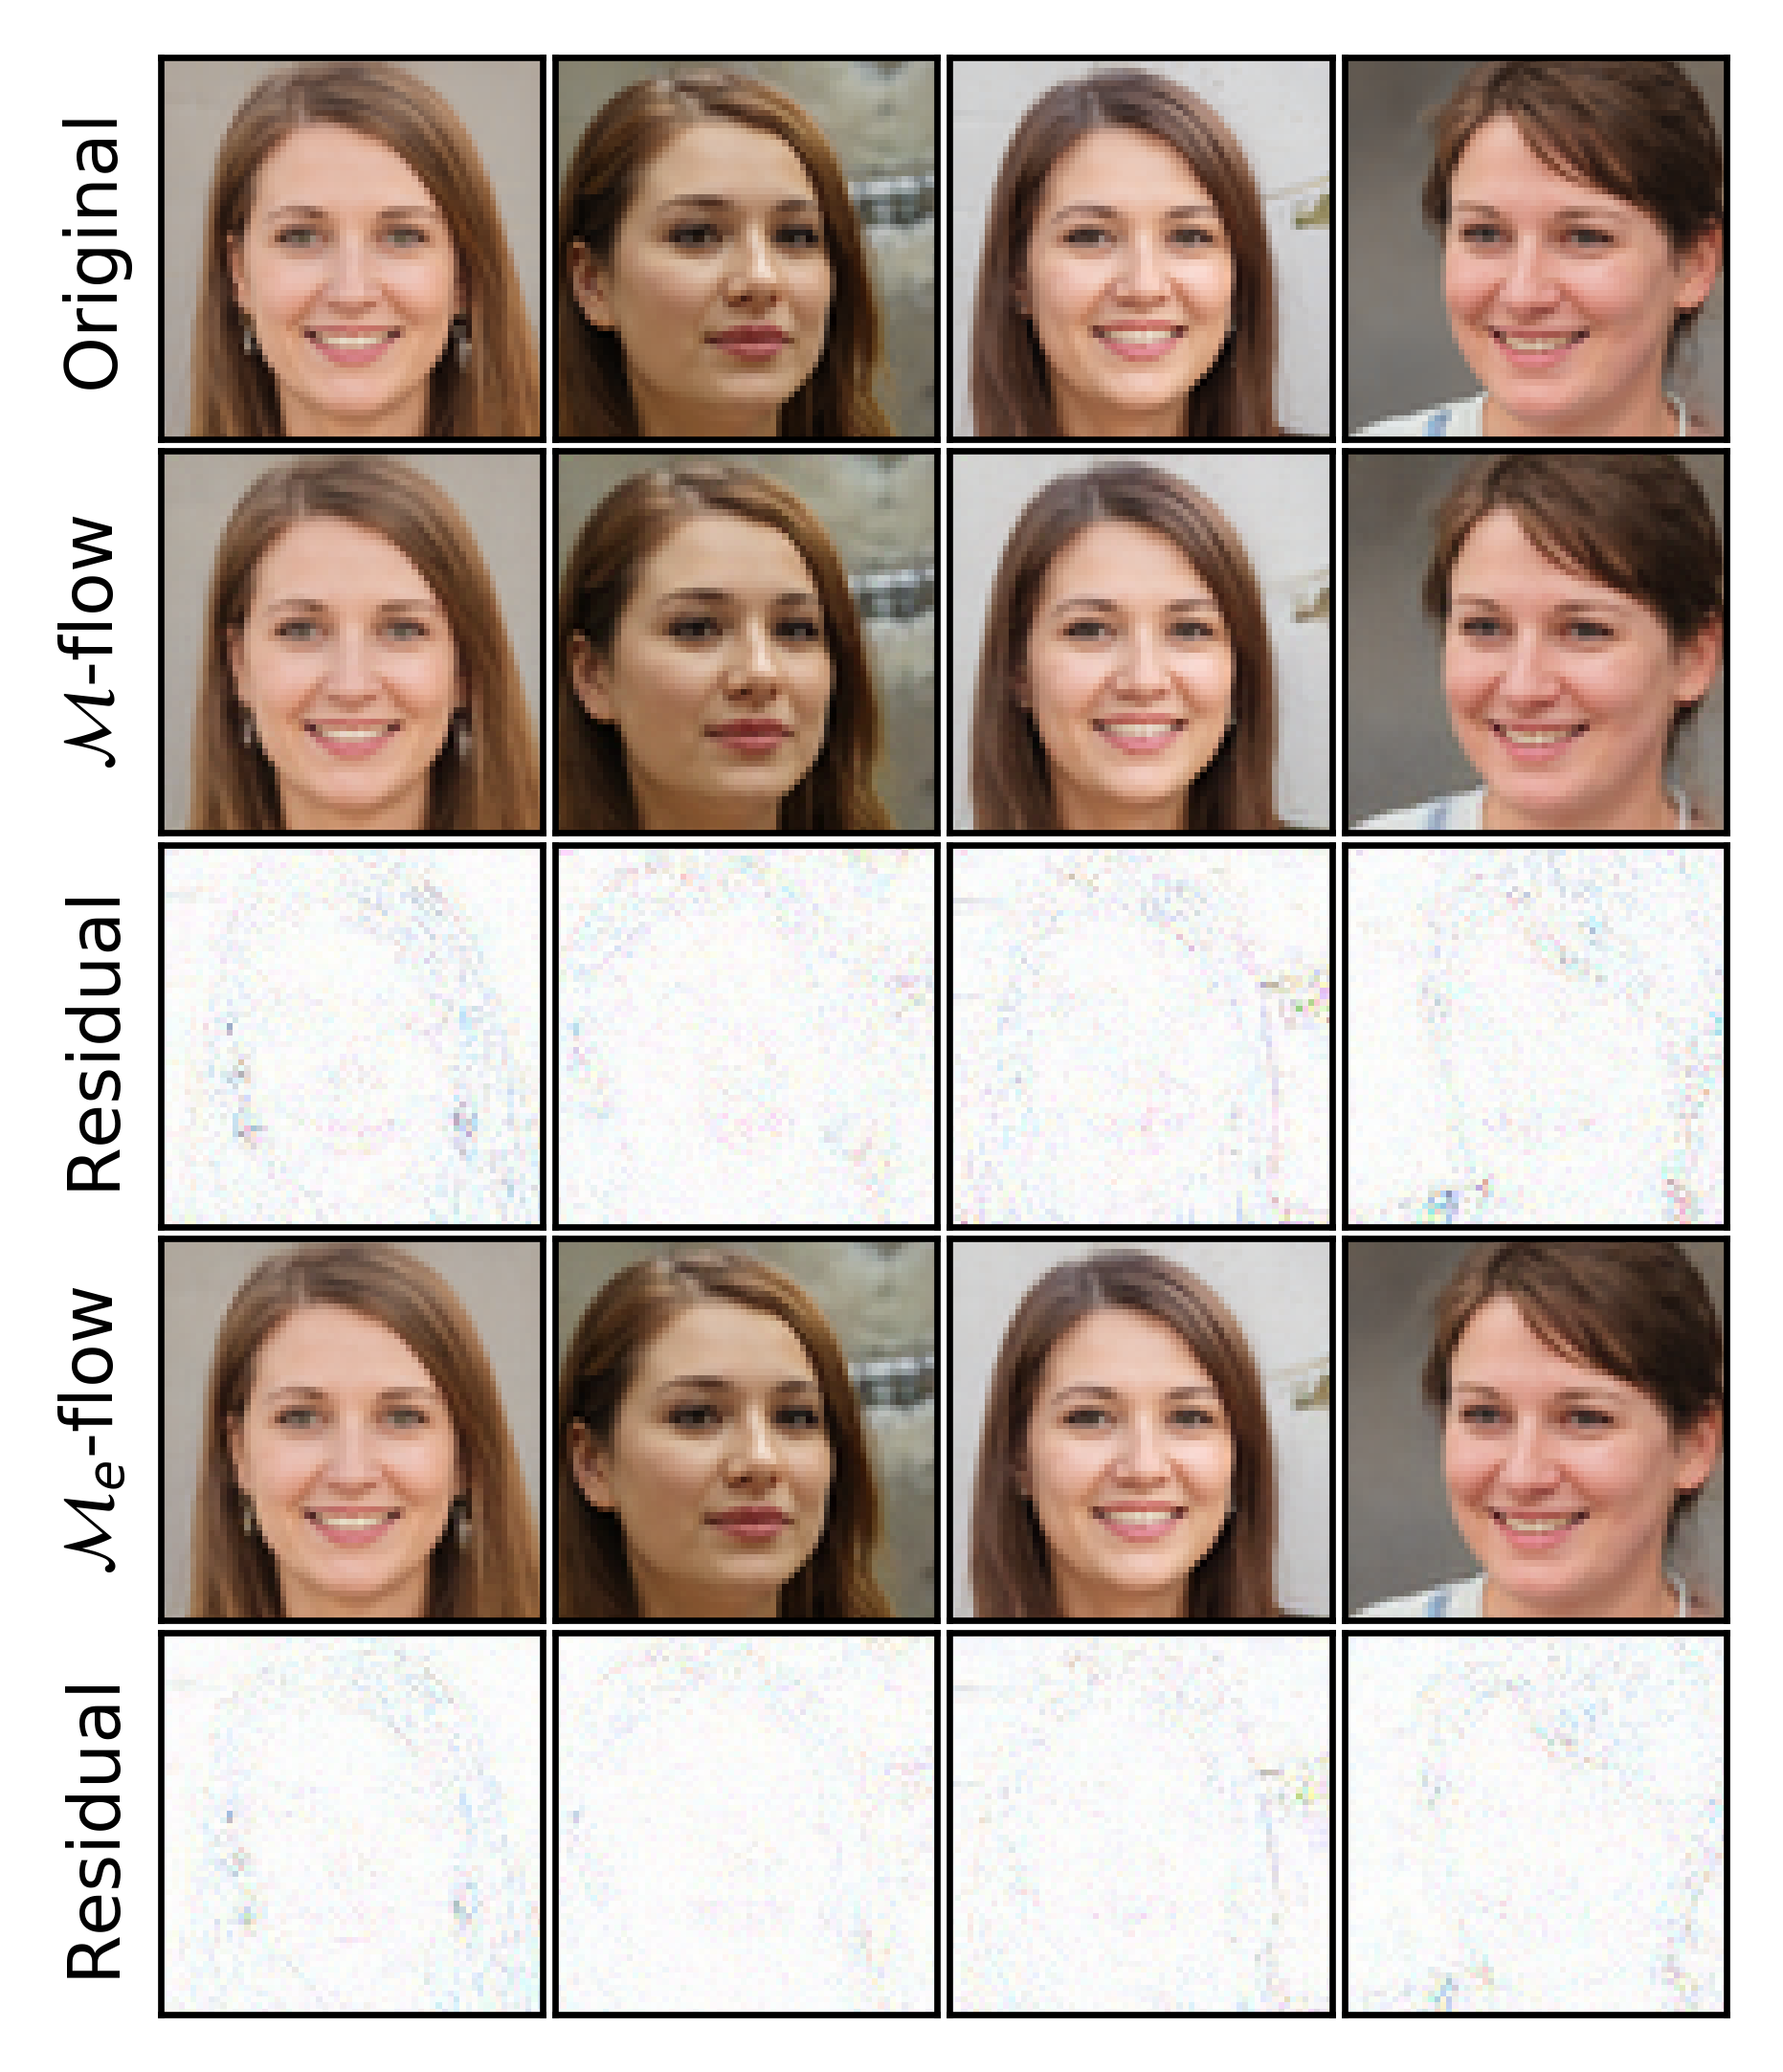

In [49]:
nrows = 5
ncols = 4
enhance = 4
labels = ["Original", "$\mathcal{M}$-flow", r"Residual", "$\mathcal{M}_e$-flow", "Residual"]

fig, gs = ps.grid_width(ncols, nrows, width=0.33 * ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    xs = [
        trf(x_test[i]),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * ncols + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan2d_projections_small.pdf")


## Training samples

In [ ]:
loader = FFHQStyleGAN2DLoader()
data = loader.load_dataset(train=False, dataset_dir="../data/samples/gan2d")
    
fig = plt.figure(figsize=(5*3., 4*3.))

for i in range(20):
    x, _ = data[np.random.randint(len(data) - 1)]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
